In [12]:
import numpy as np
from scipy.signal import welch
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [13]:
pt = "lzy"
X_train = np.load(f"{pt}/X_train.npy")
X_val = np.load(f"{pt}/X_val.npy")
X_test = np.load(f"{pt}/X_test.npy")
y_train = np.load(f"{pt}/y_train.npy")
y_val = np.load(f"{pt}/y_val.npy")
y_test = np.load(f"{pt}/y_test.npy")

In [14]:
def extract_spectral_features(X, fs=250):
    """
    Extract 1–40 Hz spectral power features using Welch's method for each EEG channel.
    
    Parameters:
        X (ndarray): EEG data, shape (N, C, T)
        fs (int): Sampling frequency

    Returns:
        features (ndarray): Flattened PSD features, shape (N, C * F_in_band)
    """
    n_samples, n_channels, n_timepoints = X.shape
    features = []

    for sample in X:
        sample_feats = []
        for ch in range(n_channels):
            freqs, psd = welch(sample[ch], fs=fs, nperseg=256)
            # Keep only 1–40 Hz
            mask = (freqs >= 1) & (freqs <= 40)
            psd_band = psd[mask]
            sample_feats.extend(psd_band)
        features.append(sample_feats)

    return np.array(features)

In [15]:
# 特征提取
X_train_feats = extract_spectral_features(X_train)
X_test_feats = extract_spectral_features(X_test)

# 模型训练
reg = Ridge(alpha=1.0)  # Ridge回归可以防止过拟合
reg.fit(X_train_feats, y_train)

# 预测
y_pred = reg.predict(X_test_feats)

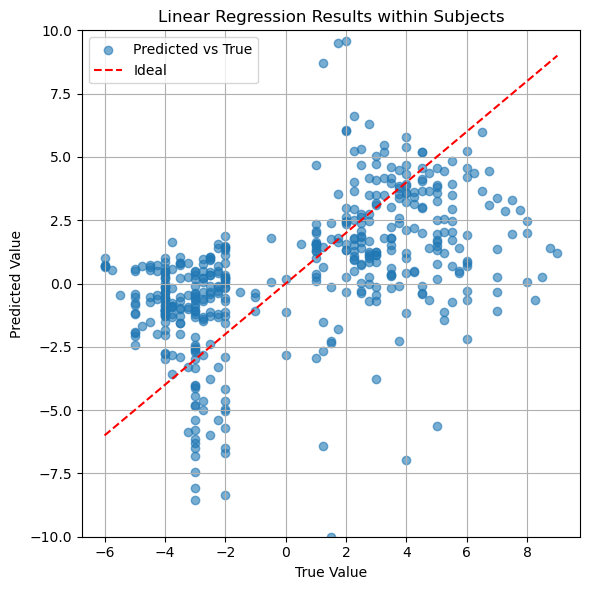

Test MSE: 11.0109
Pearson correlation: 0.5179


In [17]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("Linear Regression Results within Subjects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
corr, _ = pearsonr(y_test, y_pred)
print(f"Pearson correlation: {corr:.4f}")

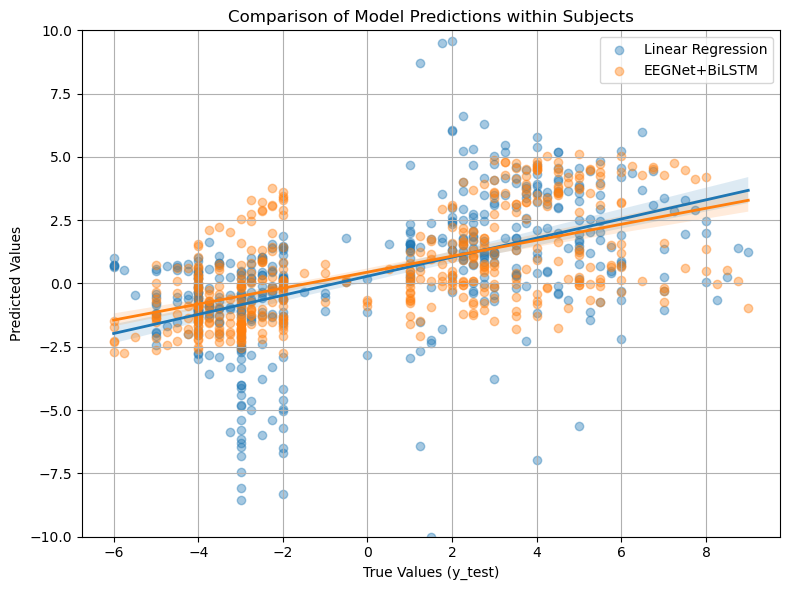

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

y_test
y_pred_linear = y_pred
y_pred_EEGNetBiLSTM = np.load(f'{pt}/{pt}_pred.npy').reshape(-1)

# 构建DataFrame方便绘图
df = pd.DataFrame({
    "y_test": np.concatenate([y_test, y_test]),
    "y_pred": np.concatenate([y_pred_linear, y_pred_EEGNetBiLSTM]),
    "model": ["Linear Regression"] * len(y_test) + ["EEGNet+BiLSTM"] * len(y_test)
})

# 设置画布大小
plt.figure(figsize=(8, 6))

# 使用 regplot 绘制每个模型的回归线
for model_name in df["model"].unique():
    subset = df[df["model"] == model_name]
    sns.regplot(
        x="y_test", y="y_pred", data=subset,
        label=model_name, scatter_kws={"alpha": 0.4}, line_kws={"linewidth": 2}
    )

# 设置图例、标题等
plt.legend()
plt.title("Comparison of Model Predictions within Subjects")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()